## Hierarchical Regression Demo

most of this code is taken from a blogpost from one of the PYMC3 developers https://twiecki.io/blog/2017/02/08/bayesian-hierchical-non-centered/

In [2]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import pymc3 as pm 
import pandas as pd
import theano
import seaborn as sns

sns.set_style('whitegrid')
np.random.seed(123)

data = pd.read_csv('https://raw.githubusercontent.com/pymc-devs/pymc4/master/notebooks/data/radon.csv')
data['log_radon'] = data['log_radon'].astype(theano.config.floatX)
county_names = data.county.unique()
county_idx = data.county_code.values

n_counties = len(data.county.unique())

In [3]:
with pm.Model() as hierarchical_model_centered:
    # Hyperpriors for group nodes
    mu_a = pm.Normal('mu_a', mu=0., sd=100**2)
    sigma_a = pm.HalfCauchy('sigma_a', 5)
    mu_b = pm.Normal('mu_b', mu=0., sd=100**2)
    sigma_b = pm.HalfCauchy('sigma_b', 5)

    # Intercept for each county, distributed around group mean mu_a
    # Above we just set mu and sd to a fixed value while here we
    # plug in a common group distribution for all a and b (which are
    # vectors of length n_counties).
    a = pm.Normal('a', mu=mu_a, sd=sigma_a, shape=n_counties)

    # Intercept for each county, distributed around group mean mu_a
    b = pm.Normal('b', mu=mu_b, sd=sigma_b, shape=n_counties)

    # Model error
    eps = pm.HalfCauchy('eps', 5)
    
    # Linear regression
    radon_est = a[county_idx] + b[county_idx] * data.floor.values
    
    # Data likelihood
    radon_like = pm.Normal('radon_like', mu=radon_est, sd=eps, observed=data.log_radon)

In [5]:
# Inference button (TM)!
with hierarchical_model_centered:
    hierarchical_centered_trace = pm.sample(draws=5000, tune=1000)[1000:]

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [eps, b, a, sigma_b, mu_b, sigma_a, mu_a]
Sampling 4 chains, 867 divergences: 100%|█| 24000/24000 [00:14<00:00, 1650.67dra
There were 658 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.6943897947556977, but should be close to 0.8. Try to increase the number of tuning steps.
There were 15 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.7088709897447307, but should be close to 0.8. Try to increase the number of tuning steps.
There were 22 divergences after tuning. Increase `target_accept` or reparameterize.
There were 172 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.7129842843152407, but should be close to 0.8. Tr

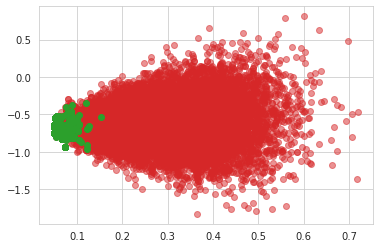

In [15]:
sigma_b_samps = hierarchical_centered_trace.get_values(varname="sigma_b")
beta01_samps = hierarchical_centered_trace.get_values(varname = "b")[:, 0]

which_divergences = hierarchical_centered_trace['diverging']
plt.plot(sigma_b_samps, beta01_samps, "o", color='C3', alpha=0.5)
plt.plot(sigma_b_samps[which_divergences], beta01_samps[which_divergences], "o", color='C2')



Reparameterizing the model...

It's still true that 

$$y_{ij} \mid a_j, b_j, \sigma^2,  x_{ij} \sim \text{Normal}(a_j + b_j x_{ij}, \sigma^2)$$

The only difference is in the priors for the regression coefficients.

Before

$$
a_j \sim \text{Normal}(\mu_a, \sigma^2_a)
$$

Now

$$
a_j = \mu_a + \tilde{a}_{j} \cdot \sigma_a \\
\tilde{a}_{j} \sim \text{Normal}(0, 1)
$$


We'll sample $\tilde{a}_{j}$s because they have a nicer distribution

In [16]:
with pm.Model() as hierarchical_model_non_centered:
    # Hyperpriors for group nodes
    mu_a = pm.Normal('mu_a', mu=0., sd=100**2)
    sigma_a = pm.HalfCauchy('sigma_a', 5)
    mu_b = pm.Normal('mu_b', mu=0., sd=100**2)
    sigma_b = pm.HalfCauchy('sigma_b', 5)

    # Before:
    # a = pm.Normal('a', mu=mu_a, sd=sigma_a, shape=n_counties)
    # Transformed:
    a_offset = pm.Normal('a_offset', mu=0, sd=1, shape=n_counties)
    a = pm.Deterministic("a", mu_a + a_offset * sigma_a)

    # Before:
    # b = pm.Normal('b', mu=mu_b, sd=sigma_b, shape=n_counties)
    # Now:
    b_offset = pm.Normal('b_offset', mu=0, sd=1, shape=n_counties)
    b = pm.Deterministic("b", mu_b + b_offset * sigma_b)

    # Model error
    eps = pm.HalfCauchy('eps', 5)
    
    radon_est = a[county_idx] + b[county_idx] * data.floor.values
    
    # Data likelihood
    radon_like = pm.Normal('radon_like', mu=radon_est, sd=eps, observed=data.log_radon)

In [17]:
# Inference button (TM)!
with hierarchical_model_non_centered:
    hierarchical_non_centered_trace = pm.sample(draws=5000, tune=1000)[1000:]

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [eps, b_offset, a_offset, sigma_b, mu_b, sigma_a, mu_a]
Sampling 4 chains, 4 divergences: 100%|█| 24000/24000 [00:12<00:00, 1925.24draws
There was 1 divergence after tuning. Increase `target_accept` or reparameterize.
There were 3 divergences after tuning. Increase `target_accept` or reparameterize.
The number of effective samples is smaller than 25% for some parameters.


/home/trb5me_admin/miniconda3/lib/python3.9/site-packages/arviz/data/io_pymc3.py:88: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  warnings.warn(


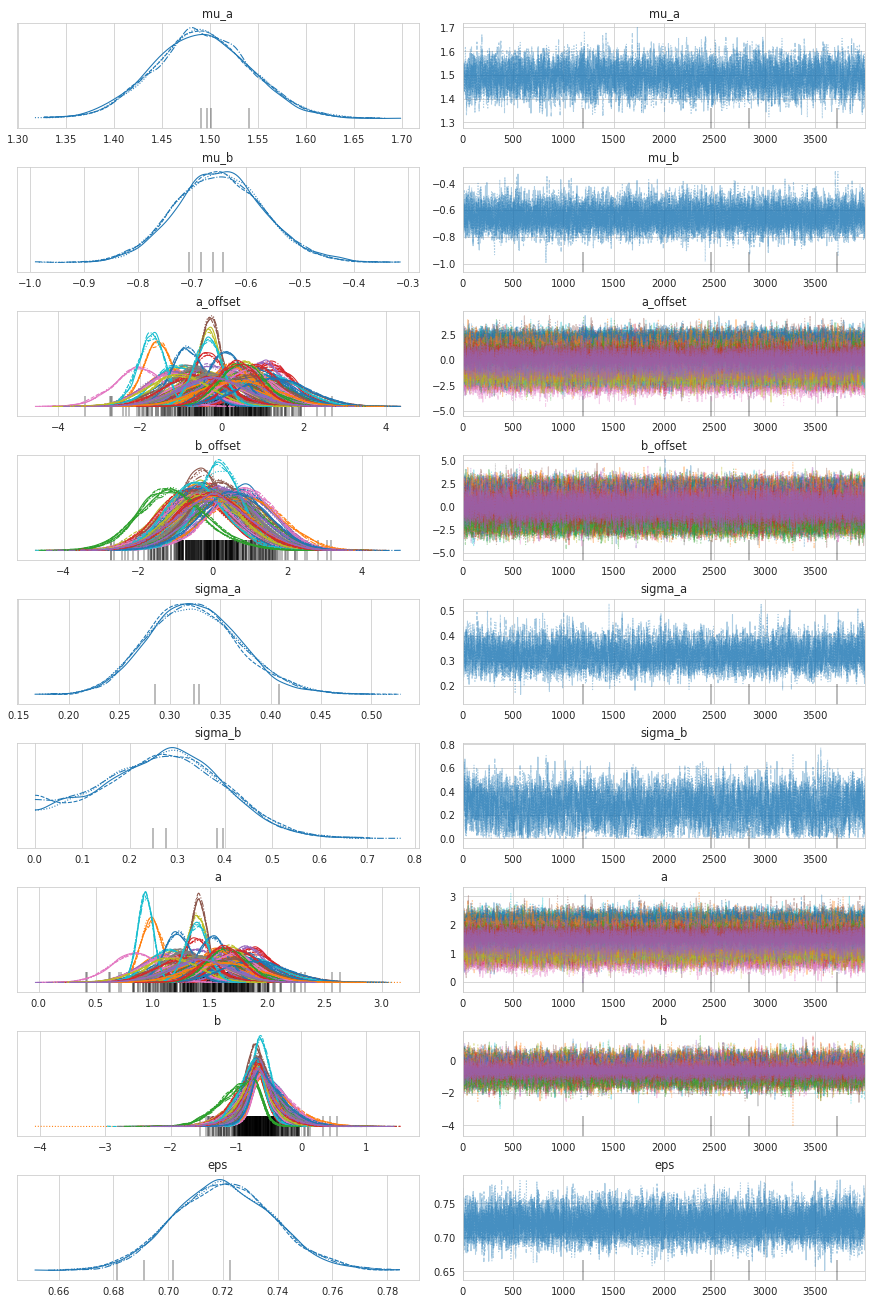

In [21]:
pm.plots.traceplot(hierarchical_non_centered_trace);

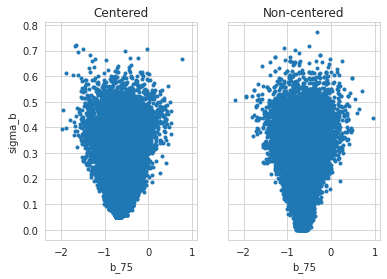

In [22]:
fig, axs = plt.subplots(ncols=2, sharex=True, sharey=True)

x = pd.Series(hierarchical_centered_trace['b'][:, 75], name='slope b_75')
y = pd.Series(hierarchical_centered_trace['sigma_b'], name='slope group variance sigma_b')

axs[0].plot(x, y, '.');
axs[0].set(title='Centered', ylabel='sigma_b', xlabel='b_75')

x = pd.Series(hierarchical_non_centered_trace['b'][:, 75], name='slope b_75')
y = pd.Series(hierarchical_non_centered_trace['sigma_b'], name='slope group variance sigma_b')

axs[1].plot(x, y, '.');
axs[1].set(title='Non-centered', xlabel='b_75');